In [99]:
from utils.analysis import Signal
from utils.plotter import Hist, Hist2d
from utils.files import *
from utils.varUtils import *
from utils.useCMSstyle import *
plt.style.use(CMS)

In [144]:
from utils.analysis.tree import Tree

In [146]:
qcd = Tree(get_qcd_ttbar('dnn'))

FileNotFoundError: file not found

    '/eos/uscms/store/user/srosenzw/sixb/ntuples/Summer2018UL/dnn/TTJets/TTJets/ntuple.root'

Files may be specified as:
   * str/bytes: relative or absolute filesystem path or URL, without any colons
         other than Windows drive letter or URL schema.
         Examples: "rel/file.root", "C:\abs\file.root", "http://where/what.root"
   * str/bytes: same with an object-within-ROOT path, separated by a colon.
         Example: "rel/file.root:tdirectory/ttree"
   * pathlib.Path: always interpreted as a filesystem path or URL only (no
         object-within-ROOT path), regardless of whether there are any colons.
         Examples: Path("rel:/file.root"), Path("/abs/path:stuff.root")

Functions that accept many files (uproot.iterate, etc.) also allow:
   * glob syntax in str/bytes and pathlib.Path.
         Examples: Path("rel/*.root"), "/abs/*.root:tdirectory/ttree"
   * dict: keys are filesystem paths, values are objects-within-ROOT paths.
         Example: {"/data_v1/*.root": "ttree_v1", "/data_v2/*.root": "ttree_v2"}
   * already-open TTree objects.
   * iterables of the above.


In [2]:
tree = Signal('/eos/uscms/store/user/srosenzw/sixb/ntuples/Summer2018UL/NMSSM_cutflow_studies/presel/NMSSM_XYH_YToHH_6b_MX_700_MY_400_1M/ntuple.root')

/eos/uscms/store/user/srosenzw/sixb/ntuples/Summer2018UL/NMSSM_cutflow_studies/presel/NMSSM_XYH_YToHH_6b_MX_700_MY_400_1M/ntuple.root


In [3]:
import awkward as ak

In [34]:
id_sort = ak.argsort(tree.jet_signalId, axis=1, ascending=False)[:,:6]
tree.jet_signalId[id_sort]

<Array [[5, 4, 3, 2, 1, 0, ... 3, 2, 1, 0, -1]] type='569341 * var * int32'>

In [63]:
sixb_event = ak.sum(tree.jet_signalId[id_sort] > -1, axis=1) == 6
combinatoric_event = ak.sum(tree.jet_signalId[id_sort] > -1, axis=1) != 6

n_sixb = ak.sum(sixb_event)

combinatoric_event = ak.local_index(tree.n_jet)[combinatoric_event][:n_sixb]
sixb_event = ak.local_index(tree.n_jet)[sixb_event]

In [ ]:
def get_features(mask):
    pt = tree.jet_ptRegressed[id_sort][mask]
    eta = abs(tree.jet_eta[id_sort][mask])
    

In [86]:
from itertools import combinations

In [87]:
combos = list(combinations(np.arange(6),2))
combos

[(0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (0, 5),
 (1, 2),
 (1, 3),
 (1, 4),
 (1, 5),
 (2, 3),
 (2, 4),
 (2, 5),
 (3, 4),
 (3, 5),
 (4, 5)]

In [93]:
from utils.analysis.particle import Particle

In [141]:
def get_min_dR(mask):
    dR_dict = {}
    for i,j in combos:
        particle1 = Particle(kin_dict={
            'pt' : tree.jet_ptRegressed[id_sort][mask][:,i],
            'eta' : tree.jet_eta[id_sort][mask][:,i],
            'phi' : tree.jet_phi[id_sort][mask][:,i],
            'm' : tree.jet_mRegressed[id_sort][mask][:,i]
            })
        
        particle2 = Particle(kin_dict={
            'pt' : tree.jet_ptRegressed[id_sort][mask][:,j],
            'eta' : tree.jet_eta[id_sort][mask][:,j],
            'phi' : tree.jet_phi[id_sort][mask][:,j],
            'm' : tree.jet_mRegressed[id_sort][mask][:,j]
            })
        
        dR_dict[f"{i}{j}"] = particle1.deltaPhi(particle2)
    min_dR = np.column_stack([dR_dict[key].to_numpy() for key in dR_dict.keys()]).min(axis=1)
    return min_dR

In [142]:
min_dR_sixb = get_min_dR(sixb_event)
min_dR_comb = get_min_dR(combinatoric_event)

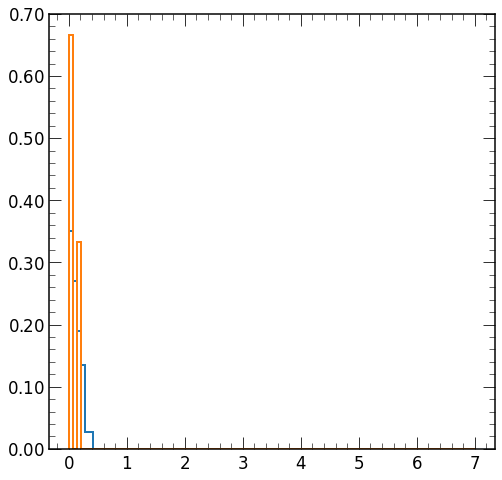

In [143]:
fig, ax = plt.subplots()

_ = Hist(min_dR_sixb, bins=np.linspace(0,7,100), ax=ax)
_ = Hist(min_dR_comb, bins=np.linspace(0,7,100), ax=ax)

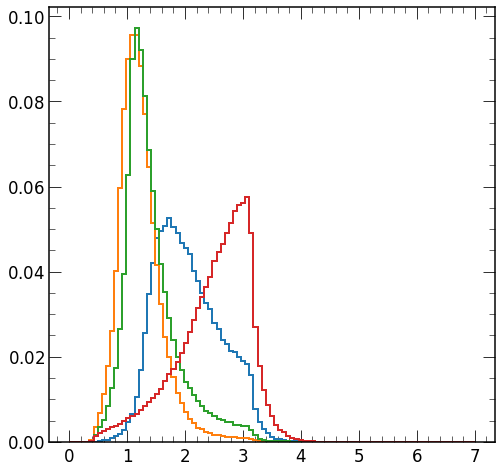

In [105]:
fig, ax = plt.subplots()

_ = Hist(dR_dict['01'], bins=np.linspace(0,7,100), ax=ax)
_ = Hist(dR_dict['23'], bins=np.linspace(0,7,100), ax=ax)
_ = Hist(dR_dict['45'], bins=np.linspace(0,7,100), ax=ax)

In [118]:
min_dR = np.column_stack((
    dR_dict['01'].to_numpy(),
    dR_dict['23'].to_numpy(),
    dR_dict['45'].to_numpy())).min(axis=1)

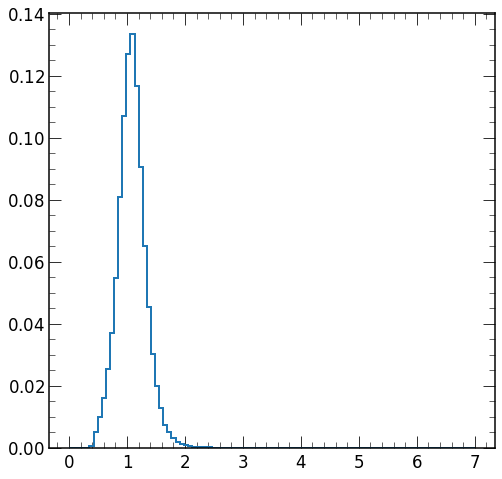

In [120]:
fig, ax = plt.subplots()

_ = Hist(min_dR, bins=np.linspace(0,7,100), ax=ax)